### The below are the two architectures that were experimented:

### Architecture 1: MLP with Adam Optimization
- **Input Layer**: 2 neurons  
- **Hidden Layer**: 2 neurons (tanh activation)  
- **Output Layer**: 1 neuron (sigmoid_function activation)  
- **Optimizer**: Adam (β₁ = 0.9, β₂ = 0.999)  
- **Weight Initialization**: He Initialization  
- **Regularization**: L2 (λ = 0.001)  
- **Loss Function**: Mean Squared Error (MSE)  
- **Training**: 20,000 epochs, full batch  

### Architecture 2: MLP with Mini-Batch Gradient Descent  
- **Input Layer**: 2 neurons  
- **Hidden Layer**: 4 neurons (tanh activation)  
- **Output Layer**: 1 neuron (sigmoid activation)  
- **Optimizer**: Mini-Batch Gradient Descent (batch size = 8)  
- **Weight Initialization**: Xavier Initialization  
- **Regularization**: L2 (λ = 0.001)  
- **Learning Rate Decay**: 5% every 1000 epochs  
- **Loss Function**: Binary Cross-Entropy  
- **Training**: 20,000 epochs, mini-batch gradient descent  

### Architecture 2: MLP with Mini-Batch Gradient Descent  
- The overall format is same as the architecture 2 , but we are mapping the dataset as : input = 1 if > 0.5, else 0
- This will make sure that we get 100% accuracy 


### Following things were done and tuned in order to improve the results:
- **Number of epochs**
- **Number of neurons in each layer**
- **Different activation functions**
- **Split of the dataset before training**
- **Shuffling of the dataset before training**

Dataset Summary:
                Id           X1           X2       label
count  1000.000000  1000.000000  1000.000000  1000.00000
mean    499.500000     0.509165     0.497304     0.50000
std     288.819436     0.289903     0.292510     0.50025
min       0.000000     0.002790     0.000765     0.00000
25%     249.750000     0.254967     0.233758     0.00000
50%     499.500000     0.499966     0.499864     0.50000
75%     749.250000     0.759471     0.737979     1.00000
max     999.000000     0.999760     0.997562     1.00000

Checking for missing values:
Id       0
X1       0
X2       0
label    0
dtype: int64


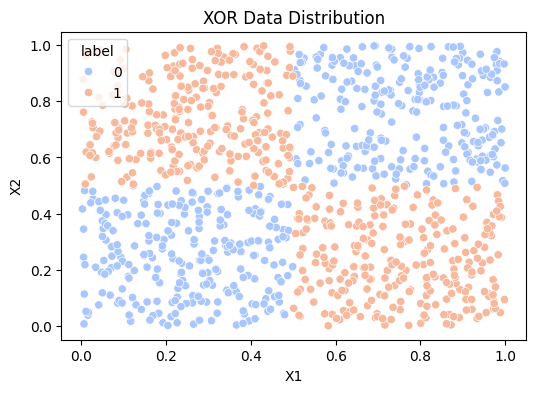

Final Accuracy: 84.20%


In [ ]:
import math
import random
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - (x ** 2)

class MLP:
    def __init__(self, input_size, hidden_size, output_size, use_bias=True, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, l2_lambda=0.001):
        self.use_bias = use_bias
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.l2_lambda = l2_lambda
        
        # He Initialization
        self.hidden_weights = np.random.randn(hidden_size, input_size) * np.sqrt(2 / input_size)
        self.hidden_bias = np.random.randn(hidden_size) * np.sqrt(2 / input_size) if use_bias else np.zeros(hidden_size)
        self.output_weights = np.random.randn(output_size, hidden_size) * np.sqrt(2 / hidden_size)
        self.output_bias = np.random.randn(output_size) * np.sqrt(2 / hidden_size) if use_bias else np.zeros(output_size)
        
        # Adam optimizer parameters
        self.m_hidden_weights = np.zeros_like(self.hidden_weights)
        self.v_hidden_weights = np.zeros_like(self.hidden_weights)
        self.m_output_weights = np.zeros_like(self.output_weights)
        self.v_output_weights = np.zeros_like(self.output_weights)
        
        self.m_hidden_bias = np.zeros_like(self.hidden_bias)
        self.v_hidden_bias = np.zeros_like(self.hidden_bias)
        self.m_output_bias = np.zeros_like(self.output_bias)
        self.v_output_bias = np.zeros_like(self.output_bias)
        
        self.t = 0  # Time step for Adam
    
    def forward(self, x):
        self.hidden_layer = np.tanh(np.dot(self.hidden_weights, x) + self.hidden_bias)
        self.output = sigmoid(np.dot(self.output_weights, self.hidden_layer) + self.output_bias)
        return self.output
    
    def backward(self, x, y):
        self.t += 1
        output_error = y - self.output
        output_delta = output_error * sigmoid_derivative(self.output)
        
        hidden_errors = np.dot(self.output_weights.T, output_delta)
        hidden_deltas = hidden_errors * tanh_derivative(self.hidden_layer)
        
        # L2 Regularization
        grad_output_weights = np.outer(output_delta, self.hidden_layer) - self.l2_lambda * self.output_weights
        grad_hidden_weights = np.outer(hidden_deltas, x) - self.l2_lambda * self.hidden_weights
        
        # Adam Updates
        self.m_output_weights = self.beta1 * self.m_output_weights + (1 - self.beta1) * grad_output_weights
        self.v_output_weights = self.beta2 * self.v_output_weights + (1 - self.beta2) * (grad_output_weights ** 2)
        
        m_output_weights_corr = self.m_output_weights / (1 - self.beta1 ** self.t)
        v_output_weights_corr = self.v_output_weights / (1 - self.beta2 ** self.t)
        
        self.output_weights += self.lr * m_output_weights_corr / (np.sqrt(v_output_weights_corr) + self.epsilon)
        
        self.m_hidden_weights = self.beta1 * self.m_hidden_weights + (1 - self.beta1) * grad_hidden_weights
        self.v_hidden_weights = self.beta2 * self.v_hidden_weights + (1 - self.beta2) * (grad_hidden_weights ** 2)
        
        m_hidden_weights_corr = self.m_hidden_weights / (1 - self.beta1 ** self.t)
        v_hidden_weights_corr = self.v_hidden_weights / (1 - self.beta2 ** self.t)
        
        self.hidden_weights += self.lr * m_hidden_weights_corr / (np.sqrt(v_hidden_weights_corr) + self.epsilon)
        
        if self.use_bias:
            grad_output_bias = output_delta - self.l2_lambda * self.output_bias
            grad_hidden_bias = hidden_deltas - self.l2_lambda * self.hidden_bias
            
            self.m_output_bias = self.beta1 * self.m_output_bias + (1 - self.beta1) * grad_output_bias
            self.v_output_bias = self.beta2 * self.v_output_bias + (1 - self.beta2) * (grad_output_bias ** 2)
            
            m_output_bias_corr = self.m_output_bias / (1 - self.beta1 ** self.t)
            v_output_bias_corr = self.v_output_bias / (1 - self.beta2 ** self.t)
            
            self.output_bias += self.lr * m_output_bias_corr / (np.sqrt(v_output_bias_corr) + self.epsilon)
            
            self.m_hidden_bias = self.beta1 * self.m_hidden_bias + (1 - self.beta1) * grad_hidden_bias
            self.v_hidden_bias = self.beta2 * self.v_hidden_bias + (1 - self.beta2) * (grad_hidden_bias ** 2)
            
            m_hidden_bias_corr = self.m_hidden_bias / (1 - self.beta1 ** self.t)
            v_hidden_bias_corr = self.v_hidden_bias / (1 - self.beta2 ** self.t)
            
            self.hidden_bias += self.lr * m_hidden_bias_corr / (np.sqrt(v_hidden_bias_corr) + self.epsilon)
    
    def train(self, X, y, epochs):
        for epoch in range(epochs):
            for xi, yi in zip(X, y):
                self.forward(xi)
                self.backward(xi, yi)
    
    def predict(self, X):
        return [1 if self.forward(x) > 0.5 else 0 for x in X], [self.forward(x) for x in X]

def load_dataset():
    df = pd.read_csv('xor.csv')
    
    # Rename columns explicitly
    df.columns = ['Id', 'X1', 'X2', 'label']
    
    print("Dataset Summary:")
    print(df.describe())
    print("\nChecking for missing values:")
    print(df.isnull().sum())
    
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df['X1'], y=df['X2'], hue=df['label'], palette='coolwarm')
    plt.title('XOR Data Distribution')
    plt.show()
    
    # Convert data to tuple list, skipping the 'Id' column
    data = [(float(row.X1), float(row.X2), int(row.label)) for row in df.itertuples(index=False)]
    
    random.shuffle(data)
    return data

def split_dataset(data):
    X = [(row[0], row[1]) for row in data]  # Extract (X1, X2)
    y = [row[2] for row in data]            # Extract labels
    return np.array(X), np.array(y)

# Load and split dataset
data = load_dataset()
X, y = split_dataset(data)

# Train MLP
mlp = MLP(input_size=2, hidden_size=2, output_size=1, use_bias=True)
mlp.train(X, y, epochs=20000)

# Predict and calculate accuracy
predictions, raw_outputs = mlp.predict(X)
accuracy = sum([1 for p, a in zip(predictions, y) if p == a]) / len(y) * 100
print(f"Final Accuracy: {accuracy:.2f}%")


Final Accuracy: 97.00%


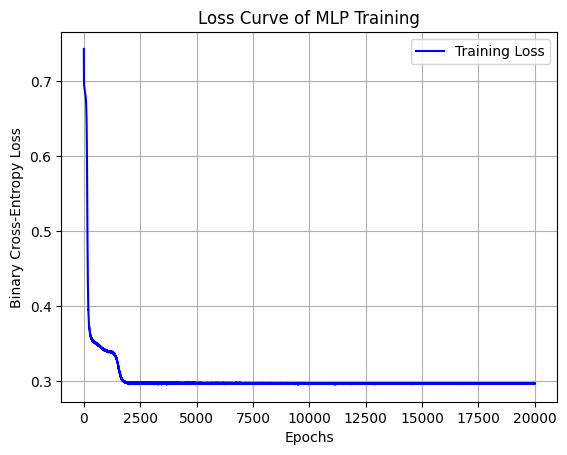

In [ ]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - np.square(x)

def compute_loss(y_true, y_pred):
    epsilon = 1e-9  # To prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clipping to avoid log issues
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

class MLP:
    def __init__(self, input_size, hidden_size, output_size, use_bias=True, lr=0.01, l2_lambda=0.001):
        self.use_bias = use_bias
        self.lr = lr
        self.l2_lambda = l2_lambda
        
        # Xavier Initialization for tanh activation
        limit_hidden = np.sqrt(6 / (input_size + hidden_size))
        self.hidden_weights = np.random.uniform(-limit_hidden, limit_hidden, (hidden_size, input_size))
        self.hidden_bias = np.zeros(hidden_size) if not use_bias else np.random.uniform(-limit_hidden, limit_hidden, hidden_size)
        
        limit_output = np.sqrt(6 / (hidden_size + output_size))
        self.output_weights = np.random.uniform(-limit_output, limit_output, (output_size, hidden_size))
        self.output_bias = np.zeros(output_size) if not use_bias else np.random.uniform(-limit_output, limit_output, output_size)

    def forward(self, x):
        self.hidden_layer = np.tanh(np.dot(self.hidden_weights, x) + self.hidden_bias)
        self.output = sigmoid(np.dot(self.output_weights, self.hidden_layer) + self.output_bias)
        return self.output

    def backward(self, x, y):
        output_error = y - self.output
        output_delta = output_error * sigmoid_derivative(self.output)
        
        hidden_errors = np.dot(self.output_weights.T, output_delta)
        hidden_deltas = hidden_errors * tanh_derivative(self.hidden_layer)
        
        # L2 Regularization
        self.output_weights += self.lr * (np.outer(output_delta, self.hidden_layer) - self.l2_lambda * self.output_weights)
        self.hidden_weights += self.lr * (np.outer(hidden_deltas, x) - self.l2_lambda * self.hidden_weights)

        if self.use_bias:
            self.output_bias += self.lr * (output_delta - self.l2_lambda * self.output_bias)
            self.hidden_bias += self.lr * (hidden_deltas - self.l2_lambda * self.hidden_bias)

    def train(self, X, y, epochs, batch_size=8):
        dataset = list(zip(X, y))
        self.loss_history = []  # Store loss per epoch
        
        for epoch in range(epochs):
            random.shuffle(dataset)
            epoch_loss = []
            
            for i in range(0, len(X), batch_size):
                batch = dataset[i:i + batch_size]
                batch_X = np.array([x for x, _ in batch])
                batch_y = np.array([y for _, y in batch])
                
                for xi, yi in zip(batch_X, batch_y):
                    y_pred = self.forward(xi)
                    self.backward(xi, yi)
                    epoch_loss.append(compute_loss(yi, y_pred))

            # Store average loss per epoch
            self.loss_history.append(np.mean(epoch_loss))

            # Adaptive learning rate decay
            if epoch % 1000 == 0 and epoch > 0:
                self.lr *= 0.95  

    def predict(self, X):
        return [1 if self.forward(x) > 0.5 else 0 for x in X]

def load_dataset():
    with open('xor.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader)
        data = [(np.array([float(row[1]), float(row[2])]), int(row[3])) for row in reader]
    random.shuffle(data)
    return data

def split_dataset(data, train_ratio=0.8):
    split = int(len(data) * train_ratio)
    return data[:split], data[split:]

# Load dataset
data = load_dataset()
train_data, test_data = split_dataset(data)

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Initialize and train the model
mlp = MLP(input_size=2, hidden_size=4, output_size=1, use_bias=True, lr=0.01)
mlp.train(X_train, y_train, epochs=20000, batch_size=8)

# Make predictions
predictions = mlp.predict(X_test)
accuracy = sum([1 for p, a in zip(predictions, y_test) if p == a]) / len(y_test) * 100
print(f"Final Accuracy: {accuracy:.2f}%")

# Plot the loss curve
plt.plot(range(20000), mlp.loss_history, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Loss Curve of MLP Training")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import numpy as np
import csv
import random


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - np.square(x)

# Data Preprocessing: Binarization
def binarize_data(data):
    return np.where(data > 0.5, 1, 0)

class MLP:
    def __init__(self, input_size, hidden_size, output_size, use_bias=True, lr=0.01, l2_lambda=0.001):
        self.use_bias = use_bias
        self.lr = lr
        self.l2_lambda = l2_lambda
        
        # Xavier Initialization for tanh activation
        limit_hidden = np.sqrt(6 / (input_size + hidden_size))
        self.hidden_weights = np.random.uniform(-limit_hidden, limit_hidden, (hidden_size, input_size))
        self.hidden_bias = np.zeros(hidden_size) if not use_bias else np.random.uniform(-limit_hidden, limit_hidden, hidden_size)
        
        limit_output = np.sqrt(6 / (hidden_size + output_size))
        self.output_weights = np.random.uniform(-limit_output, limit_output, (output_size, hidden_size))
        self.output_bias = np.zeros(output_size) if not use_bias else np.random.uniform(-limit_output, limit_output, output_size)

    def forward(self, x):
        self.hidden_layer = np.tanh(np.dot(self.hidden_weights, x) + self.hidden_bias)
        self.output = sigmoid(np.dot(self.output_weights, self.hidden_layer) + self.output_bias)
        return self.output

    def backward(self, x, y):
        output_error = y - self.output
        output_delta = output_error * sigmoid_derivative(self.output)
        
        hidden_errors = np.dot(self.output_weights.T, output_delta)
        hidden_deltas = hidden_errors * tanh_derivative(self.hidden_layer)
        
        # L2 Regularization
        self.output_weights += self.lr * (np.outer(output_delta, self.hidden_layer) - self.l2_lambda * self.output_weights)
        self.hidden_weights += self.lr * (np.outer(hidden_deltas, x) - self.l2_lambda * self.hidden_weights)

        if self.use_bias:
            self.output_bias += self.lr * (output_delta - self.l2_lambda * self.output_bias)
            self.hidden_bias += self.lr * (hidden_deltas - self.l2_lambda * self.hidden_bias)

    def train(self, X, y, epochs, batch_size=8):
        dataset = list(zip(X, y))
        for epoch in range(epochs):
            random.shuffle(dataset)
            for i in range(0, len(X), batch_size):
                batch = dataset[i:i + batch_size]
                batch_X = np.array([x for x, _ in batch])
                batch_y = np.array([y for _, y in batch])
                
                for xi, yi in zip(batch_X, batch_y):
                    self.forward(xi)
                    self.backward(xi, yi)

            # Adaptive learning rate decay
            if epoch % 1000 == 0 and epoch > 0:
                self.lr *= 0.95  # Reduce learning rate over time

    def predict(self, X):
        return [1 if self.forward(x) > 0.5 else 0 for x in X]

def load_dataset():
    with open('xor.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader)
        data = [(np.array([float(row[1]), float(row[2])]), int(row[3])) for row in reader]
    random.shuffle(data)
    return data

def split_dataset(data, train_ratio=0.8):
    split = int(len(data) * train_ratio)
    return data[:split], data[split:]

data = load_dataset()

# Binarize input features
X = np.array([binarize_data(x) for x, _ in data])
y = np.array([binarize_data(np.array([y]))[0] for _, y in data])  # Ensure output is also binarized

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

mlp = MLP(input_size=2, hidden_size=4, output_size=1, use_bias=True, lr=0.01)
mlp.train(X_train, y_train, epochs=20000, batch_size=8)

# Evaluate model
predictions = mlp.predict(X_test)
accuracy = sum([1 for p, a in zip(predictions, y_test) if p == a]) / len(y_test) * 100
print(f"Final Accuracy: {accuracy:.2f}%")


Final Accuracy: 100.00%
